<a href="https://colab.research.google.com/github/playpark95/PreSTAT433-2023_Observer2/blob/main/KU_%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%8A%A4%ED%84%B0%EB%94%94_2%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        computation_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {computation_time} seconds")
        return result
    return wrapper

In [ ]:
import numpy as np
def test_fun(N=100):
    x = np.random.rand(N, 1)
    epsilon = (0.1 * np.random.randn(N, 1))

    fun_value = 0.8 * x ** 2 - 0.5 * x + np.sin(5 * x) + 0.5 * np.log(x) + epsilon
    return x, fun_value

np.random.seed(42)

N=100
x, y = test_fun(N) # data generation

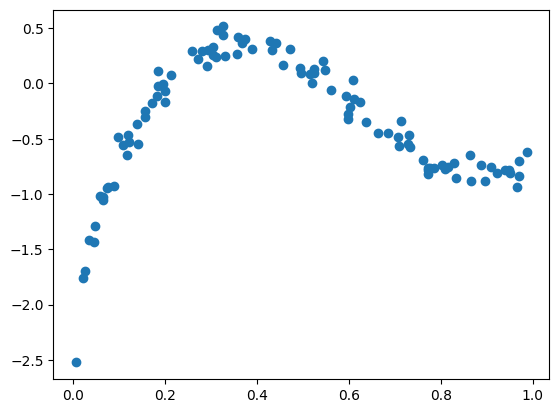

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x, y)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Shuffles the indices
idx = np.arange(N)
split_index = int(N * 0.8) # train-validation split

train_idx = idx[:split_index]
val_idx = idx[split_index:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

# create tensor at GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_train_tensor = torch.as_tensor(x_train).to(device)
y_train_tensor = torch.as_tensor(y_train).to(device)
x_val_tensor = torch.as_tensor(x_val).to(device)
y_val_tensor = torch.as_tensor(y_val).to(device)

In [ ]:
@timer
def train_model_torch(lr=0.1, epochs=1000):

    optimizer = optim.SGD(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss(reduction='mean')

    for epoch in range(epochs):
        # Loss computation
        y_hat = model(x_train_tensor)
        loss = mse_loss(y_hat, y_train_tensor)

        # Standard PyTorch code for training
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Evaluate train loss
    print("train loss:{}".format(loss))

    # Evaluate test loss
    y_hat_val = model(x_val_tensor)
    test_loss = mse_loss(y_hat_val, y_val_tensor).detach()

    print("test loss:{}".format(test_loss))

In [ ]:
!pip install torchviz
from torchviz import make_dot

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=b657c56b32bc8c013b4478f5624fe5c73389803e4389bab66acdeb5c8922df79
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch.nn as nn

class NonlinearRegression(nn.Module):
    def __init__(self, hidden_variable=10):
        super().__init__()
        # To make "b" and "w" real parameters of the model,
        # we need to wrap them with nn.Parameter
        self.hidden_variable = hidden_variable
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float64))
        self.w1 = nn.Parameter(torch.randn((1, self.hidden_variable),
                                          requires_grad=True, dtype=torch.float64))
        self.w2 = nn.Parameter(torch.randn((self.hidden_variable, 1),
                                          requires_grad=True, dtype=torch.float64))
    def forward(self, x):
    # Computes the outputs / predictions
        return torch.tanh_(self.b + x @ self.w1) @ self.w2

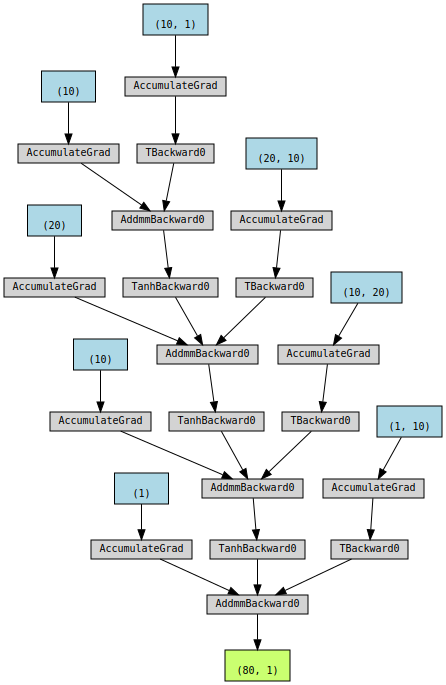

In [ ]:
class DeepRegression(nn.Module):
    def __init__(self, hidden_variables=[10, 20, 10], input_output_dim=(1, 1)):
        super().__init__()
        # Concise Implementation
        self.input_variable_dim = input_output_dim[0]
        self.output_variable_dim = input_output_dim[1]
        self.list_hidden_variable = hidden_variables
        self.layer = nn.Sequential()

        variable_dim = self.input_variable_dim
        for i, hidden_variable in enumerate(self.list_hidden_variable):
            self.layer.add_module('layer_' + str(i), nn.Linear(variable_dim, hidden_variable, dtype=torch.float64))
            self.layer.add_module('activation_' + str(i), nn.Tanh())
            variable_dim = hidden_variable
        self.layer.add_module('final_layer', nn.Linear(variable_dim, self.output_variable_dim, dtype=torch.float64))

    def forward(self, x):
    # Computes the outputs / predictions
        y_hat = self.layer(x)
        return y_hat

model = DeepRegression().to(device)
make_dot(model(x_train_tensor))

train loss:0.015076742477374672
test loss:0.010075111983040461
Execution time of train_model_torch: 0.9161796569824219 seconds


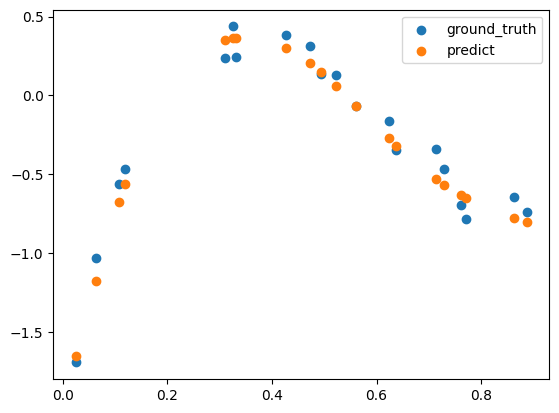

In [ ]:
train_model_torch(lr=0.1)

y_val_predict = model(x_val_tensor).cpu().detach().numpy()
plt.scatter(x_val, y_val, label='ground_truth')
plt.scatter(x_val, y_val_predict, label='predict')
plt.legend()
plt.show()

## AutoGrad and Customized Function

In [ ]:
def custom_fun(x):
    x_ = x.clone()
    return x_ ** 2

class customFun(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return custom_fun(x)

    @staticmethod
    def backward(ctx, grad_out):
        x, = ctx.saved_tensors
        return grad_out * 2 * x

In [ ]:
x = torch.randn(3, 3, requires_grad=True, dtype=torch.double)
# Call the class method 'apply', not 'forward' directly
print("x: {},\nfun(x):{}".format(x, customFun.apply(x)))

x: tensor([[ 0.6264, -0.3140,  0.6117],
        [-0.7530, -0.0658,  0.6626],
        [-0.6681,  0.6978, -1.4144]], dtype=torch.float64, requires_grad=True),
fun(x):tensor([[0.3923, 0.0986, 0.3742],
        [0.5670, 0.0043, 0.4390],
        [0.4464, 0.4869, 2.0005]], dtype=torch.float64,
       grad_fn=<customFunBackward>)


In [ ]:
jacobian_check = torch.autograd.gradcheck(customFun.apply, x)
hessian_check = torch.autograd.gradgradcheck(customFun.apply, x)
print("Check 1st-order gradient: {}, Check 2nd-order gradient: {}".format(jacobian_check, hessian_check))

Check 1st-order gradient: True, Check 2nd-order gradient: True


In [ ]:
class myAct(nn.Module):

    def __init__(self):
        super(myAct, self).__init__()

    def forward(self, input):
        return customFun.apply(input)

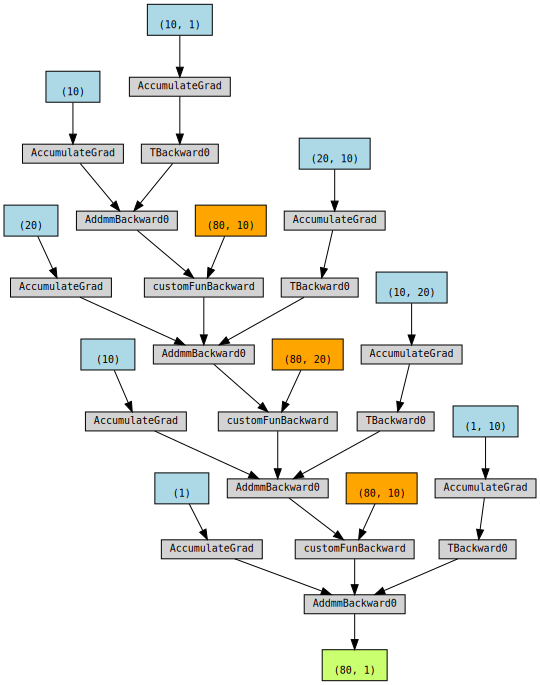

In [ ]:
class DeepRegression_v2(nn.Module):
    def __init__(self, hidden_variables=[10, 20, 10], input_output_dim=(1, 1)):
        super().__init__()
        # Concise Implementation
        self.input_variable_dim = input_output_dim[0]
        self.output_variable_dim = input_output_dim[1]
        self.list_hidden_variable = hidden_variables
        self.layer = nn.Sequential()

        variable_dim = self.input_variable_dim
        for i, hidden_variable in enumerate(self.list_hidden_variable):
            self.layer.add_module('layer_' + str(i), nn.Linear(variable_dim, hidden_variable, dtype=torch.float64))
            self.layer.add_module('custom_activation_' + str(i), myAct())
            variable_dim = hidden_variable
        self.layer.add_module('final_layer', nn.Linear(variable_dim, self.output_variable_dim, dtype=torch.float64))

    def forward(self, x):
    # Computes the outputs / predictions
        y_hat = self.layer(x)
        return y_hat

model = DeepRegression_v2().to(device)
make_dot(model(x_train_tensor))

train loss:0.022758551652332606
test loss:0.022282680766483386
Execution time of train_model_torch: 0.6173388957977295 seconds


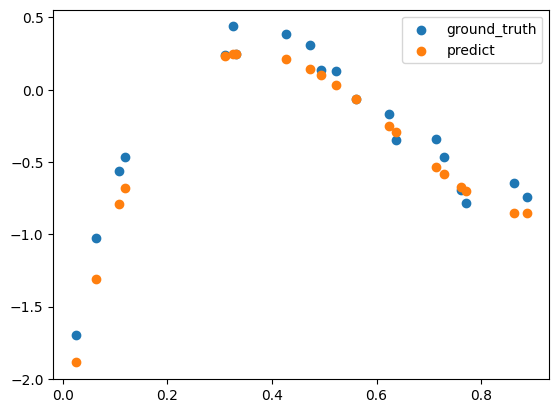

In [ ]:
train_model_torch(lr=0.1)

y_val_predict = model(x_val_tensor).cpu().detach().numpy()
plt.scatter(x_val, y_val, label='ground_truth')
plt.scatter(x_val, y_val_predict, label='predict')
plt.legend()
plt.show()

## Modularization

In [ ]:
def make_train_step(model, loss_fn, optimizer):
    def train_step_fn(x, y):

        model.train()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        return loss.item()
    return train_step_fn

In [ ]:
lr = 0.1
epochs = 1000
model = DeepRegression_v2().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')
train_step = make_train_step(model, loss_fn, optimizer)

In [ ]:
@timer
def train_model(epochs=1000):

    for epoch in range(epochs):
        loss = train_step(x_train_tensor, y_train_tensor)

        # Evaluate train loss
        if epoch % 100 == 0:
            print("train loss at {} epoch:{}".format(epoch, loss))
            train_losses.append(loss)

    # Evaluate valid loss
    with torch.no_grad():
        y_hat_val = model(x_val_tensor)
        test_loss = loss_fn(y_hat_val, y_val_tensor).detach()
        print("test loss:{}".format(test_loss))

    return test_loss

In [ ]:
train_losses = []
test_loss = train_model(epochs)

train loss at 0 epoch:0.647819881496899
train loss at 100 epoch:0.3450919045826388
train loss at 200 epoch:0.1116978226052161
train loss at 300 epoch:0.1317030077222657
train loss at 400 epoch:0.07133848502483141
train loss at 500 epoch:0.07597403392191124
train loss at 600 epoch:0.040627941895731094
train loss at 700 epoch:0.03208127687094099
train loss at 800 epoch:0.0281351776109398
train loss at 900 epoch:0.025551935396895414
test loss:0.013010960989276473
Execution time of train_model: 0.8576440811157227 seconds


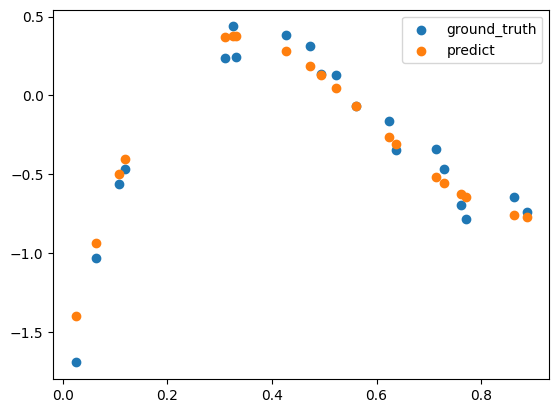

In [ ]:
y_val_predict = model(x_val_tensor).cpu().detach().numpy()
plt.scatter(x_val, y_val, label='ground_truth')
plt.scatter(x_val, y_val_predict, label='predict')
plt.legend()
plt.show()

In [ ]:
checkpoint = {'epochs': epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_loss': train_losses,
              'test_loss': test_loss
              }

torch.save(checkpoint, 'model_checkpoint.pth')

In [ ]:
del epochs, model, optimizer, train_losses, test_loss

In [ ]:
model

NameError: ignored

In [ ]:
model = DeepRegression_v2().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

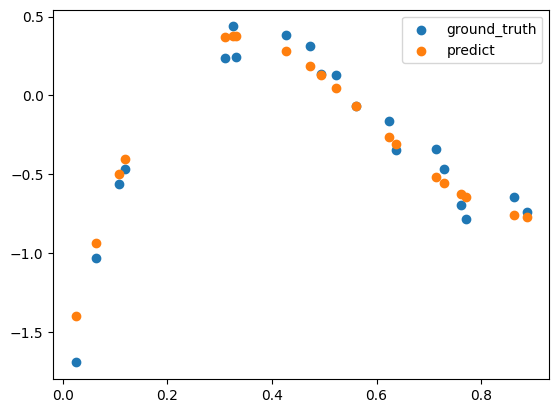

In [ ]:
y_val_predict = model(x_val_tensor).cpu().detach().numpy()
plt.scatter(x_val, y_val, label='ground_truth')
plt.scatter(x_val, y_val_predict, label='predict')
plt.legend()
plt.show()

## MNIST Classification

In [ ]:
lr = 0.1
epochs = 100
min_batch = 512

In [ ]:
import torch.utils.data as data
import torchvision as tv

train_dataset = tv.datasets.MNIST(".", download=True, train=True, transform=tv.transforms.ToTensor())
test_dataset = tv.datasets.MNIST(".", download=True, train=False, transform=tv.transforms.ToTensor())

In [ ]:
from torch.utils.data.dataloader import DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=min_batch, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=min_batch, shuffle=False)

In [ ]:
class DeepClassification(nn.Module):
    def __init__(self, hidden_variables=[128, 64, 10], input_output_dim=(28*28, 10)):
        super().__init__()
        # Concise Implementation
        self.input_variable_dim = input_output_dim[0]
        self.output_variable_dim = input_output_dim[1]
        self.list_hidden_variable = hidden_variables
        self.layer = nn.Sequential()

        variable_dim = self.input_variable_dim
        for i, hidden_variable in enumerate(self.list_hidden_variable):
            self.layer.add_module('layer_' + str(i), nn.Linear(variable_dim, hidden_variable))
            self.layer.add_module('custom_activation_' + str(i), nn.ReLU())
            variable_dim = hidden_variable
        self.layer.add_module('final_layer', nn.Linear(variable_dim, self.output_variable_dim))

    def forward(self, x):
    # Computes the outputs / predictions
        x = x.view(-1, 28*28)
        y_hat = self.layer(x)
        return y_hat

In [ ]:
model = DeepClassification().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
train_step = make_train_step(model, loss_fn, optimizer)

In [ ]:
def evaluate_step(x, y):
    y_hat = model(x)
    result = torch.sum(torch.argmax(y_hat, axis=1) == y)
    return result, len(y)

@timer
def train_model_classification(epochs=1000, eval_test_accuracy=False):
    train_losses = []
    for epoch in range(epochs):
        mini_batch_losses = []
        for x_minibatch, y_minibatch in train_loader:
            x_minibatch = x_minibatch.to(device)
            y_minibatch = y_minibatch.to(device)
            mini_batch_loss = train_step(x_minibatch, y_minibatch)
            mini_batch_losses.append(mini_batch_loss)

        # Evaluate train loss
        if (epoch + 1) % 10 == 0:
            loss = np.mean(mini_batch_losses)
            print("train loss at {} epoch:{}".format(epoch + 1, loss))
            train_losses.append(loss)

    if eval_test_accuracy:
        # Evaluate test accuracy
        with torch.no_grad():
            test_accuracy = 0
            test_result = 0
            test_cnt = 0
            for x_minibatch_test, y_minibatch_test in test_loader:
                x_minibatch_test = x_minibatch_test.to(device)
                y_minibatch_test = y_minibatch_test.to(device)
                result, cnt = evaluate_step(x_minibatch_test, y_minibatch_test)
                test_result += result
                test_cnt += cnt
            test_accuracy = 100 * test_result / test_cnt
            print("test accuracy: {}%".format(test_accuracy))

    return train_losses

In [ ]:
train_loss = train_model_classification(epochs=100, eval_test_accuracy=True)

In [ ]:
!pip install idx2numpy

In [ ]:
import gzip, idx2numpy

class custom_MNIST_train_dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, train=True, transform=None):

        self.data_dir = data_dir

        if train:
            self.input_path = 'train-images-idx3-ubyte.gz'
            self.target_path = 'train-labels-idx1-ubyte.gz'
        else:
            self.input_path = 't10k-images-idx3-ubyte.gz'
            self.target_path = 't10k-labels-idx1-ubyte.gz'

        with gzip.open(self.data_dir + self.target_path, 'rb') as target_file:
            self.target = idx2numpy.convert_from_file(target_file).reshape(-1 ,1)

        if transform is None:
            self.transform = torch.Tensor
        else:
            self.transform = transform

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):

        with gzip.open(self.data_dir + self.input_path, 'rb') as input_file:
            self.input = idx2numpy.convert_from_file(input_file)[index]

        img = self.transform(self.input)
        label = self.transform(self.target[index])

        return img, label

In [ ]:
custom_train_data = custom_MNIST_train_dataset('.', train=True)
custom_test_data = custom_MNIST_train_dataset('.', train=False)

train_loader = DataLoader(dataset=custom_train_data, batch_size=min_batch, shuffle=True)
test_loader = DataLoader(dataset=custom_test_data, batch_size=min_batch, shuffle=False)